In [1]:
import numpy as np
from ceo.mapping import Mapping
import matplotlib.pyplot as plt
import os
%matplotlib inline

/home/ubuntu/CEO/python/ceo/zemax


In [2]:
from ceo import wfpt_visulib

## Load DM .ceo file
- M1: ALPAO_BAX449.ceo
- M2: ALPAO_BAX450.ceo

In [42]:
mirror = 'M2'

if mirror=='M1':
    IFfile = 'ALPAO_BAX449'
elif mirror=='M2':
    IFfile = 'ALPAO_BAX450'

In [3]:
maps = Mapping()
maps.load(IFfile)
maps.suit

OrderedDict([('Ni', 116),
             ('L', 0.0265),
             ('N_SET', 1),
             ('N_MODE', 292),
             ('s2b', array([0, 0, 0, 0, 0, 0, 0], dtype=int32)),
             ('M', array([-0., -0., -0., ..., -0., -0., -0.]))])

In [4]:
nmodes = maps.suit['N_MODE']
ni = int(maps.suit['Ni'])
L = float(maps.suit['L'])
modes = maps.suit["M"].reshape(-1,ni,ni)
modes.shape

(292, 116, 116)

Create a circular pupil

In [5]:
v = np.arange(ni) - (ni-1)/2
xx, yy = np.meshgrid(v,v)
rr = np.sqrt(xx**2 + yy**2)
circmask = rr <= (ni)/2

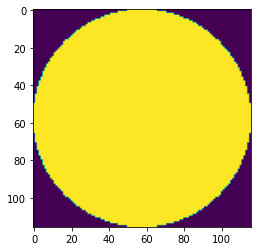

In [6]:
plt.imshow(circmask)

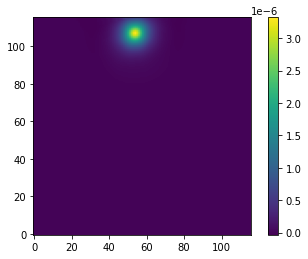

In [9]:
fig, ax = plt.subplots()
h = ax.imshow(modes[18], origin='lower')
fig.colorbar(h,ax=ax)

## Find peak values

In [10]:
IFpeak = np.zeros(nmodes)
for jj in range(nmodes):
    IFpeak[jj] = np.max(modes[jj,...] * circmask)

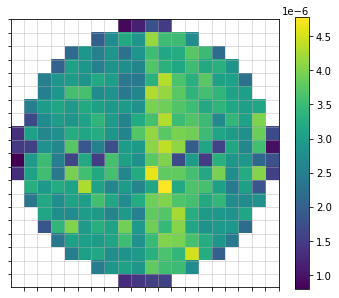

In [11]:
wfpt_visulib.show_dm292(IFpeak, grid_origin_bottom_left=True)

### Find DM IF peak location

In [12]:
maxloc = np.zeros((nmodes,2))

for jj in range(nmodes):
    ifunc = modes[jj,...] * circmask
    maxloc[jj,:] = np.unravel_index(np.argmax(ifunc), (ni,ni), order='F')

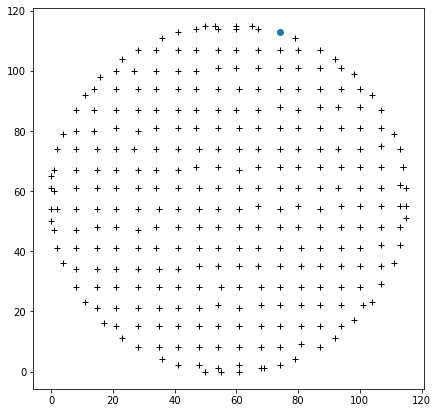

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches((7,7))
ax.plot(maxloc[:,0], maxloc[:,1], 'k+')

this_act = 5
ax.plot(maxloc[this_act,0], maxloc[this_act,1], 'o')

### Find peak value and location using 2D Gaussian fit

In [14]:
from scipy.optimize import leastsq

2D Circular Gaussian (best option for now)

In [15]:
def gaussian_func(height, center_x, center_y, width, rotation, bias):
    """
    Returns a gaussian function G(x,y) to produce a 2D Gaussian with the given parameters

    Parameters
    ----------
    height : float
        Amplitude of the Gaussian
    center_x : float
        x-coordinates of the Gaussian's center in pixels.
    center_y : float
        y-coordinates of the Gaussian's center in pixels.
    width : float
        standard deviation in pixels.
    rotation : float
        angle of rotation of the Gaussian (x,y)  axes in degrees.
    bias : float
        constant bias
    """
    width = float(np.absolute(width))
    rotation = np.deg2rad(rotation)

    def rotgauss(x,y):
        xp = (x-center_x) * np.cos(rotation) - (y-center_y) * np.sin(rotation) + center_x
        yp = (x-center_x) * np.sin(rotation) + (y-center_y) * np.cos(rotation) + center_y
        g = bias + height*np.exp( - (((center_x-xp)/width)**2+
                                     ((center_y-yp)/width)**2)/2.)
        return g
    return rotgauss

def fitgaussian(data):
    """
    Fits a 2D Gaussian to the input data, and returns the Gaussian fit parameters: (amplidute, x, y, width_x, width_y, rotation)

    Parameters
    ----------
    data : numpy 2D ndarray
        The array containing the image (i.e. the detection blob) to be fitted with a 2D Gaussian
    """
    def moments():
        total = data.sum()
        X, Y = np.indices(data.shape)
        x = (X*data).sum()/total
        y = (Y*data).sum()/total
        col = data[:, int(y)]
        width = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
        height = data.max()
        return height, x, y, width, 0.0, 0.0

    params = moments()
    errorfunction = lambda p: np.ravel( (gaussian_func(*p)(*np.indices(data.shape)) - data) * circmask )
    p, success = leastsq(errorfunction, params)
    if success != 1:
        print("gaussian fit failed....")
        return np.full(len(params),np.nan)
    return p

Test fitting procedure with a given actuator

In [16]:
this_act = 9
data = modes[this_act,...] * circmask
params = fitgaussian(data)
(gauss_height, gauss_y, gauss_x, gauss_width, gauss_rot, gauss_bias) = params

In [17]:
print("      Maximum value location: (%0.1f, %0.1f)"%(np.unravel_index(np.argmax(data),data.shape, order='F')))
print("Gaussian peak value location: (%0.1f, %0.1f)"%(gauss_x, gauss_y))

      Maximum value location: (47.0, 114.0)
Gaussian peak value location: (62.5, 31.5)


2.1093933946902308e-05
1.1071583622041356e-05
1.9762345889622562e-05


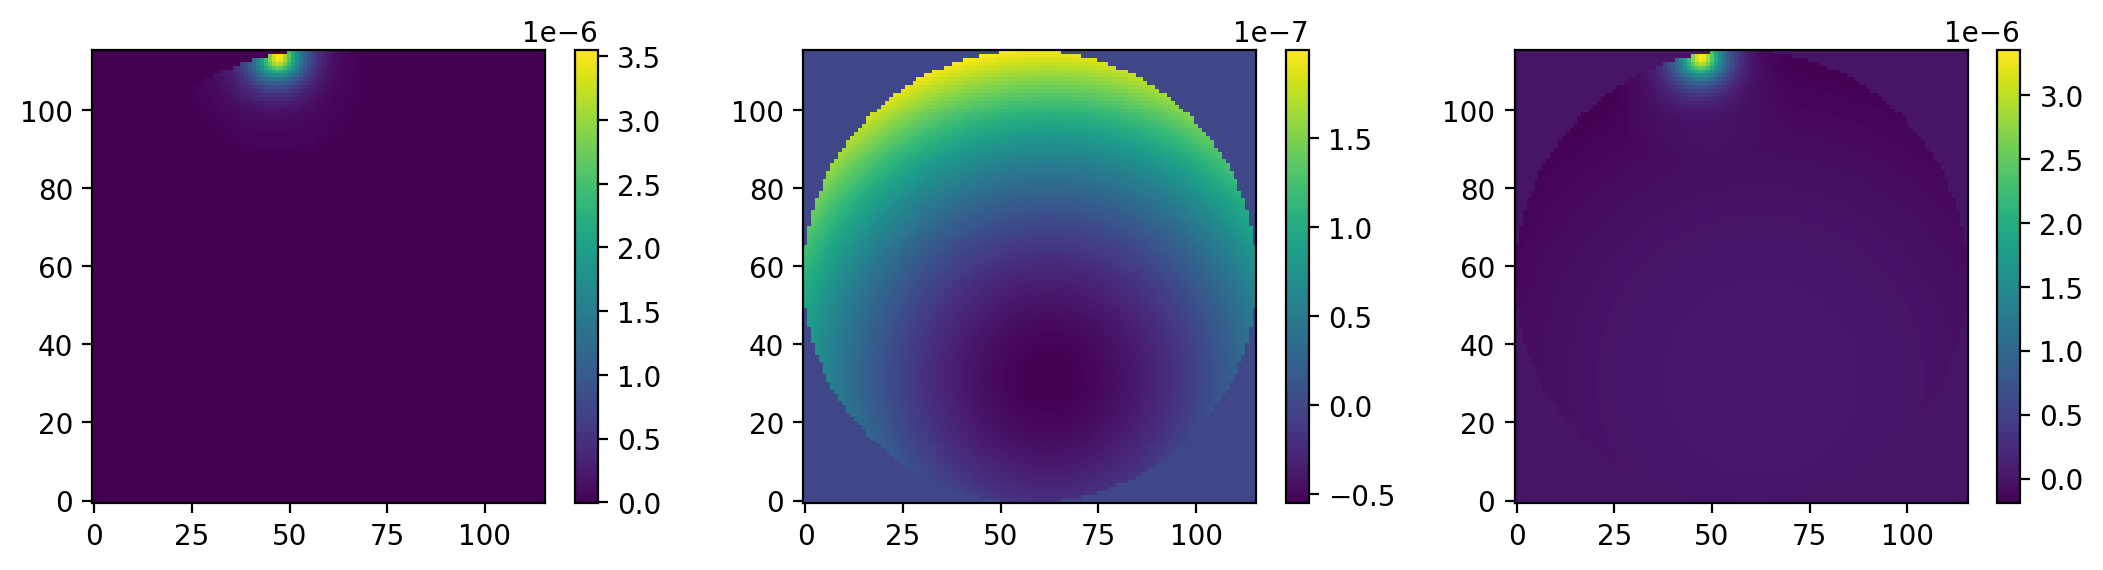

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches((13,3))
fig.dpi=200

print(np.sqrt(np.sum(data**2)))
im1 = ax1.imshow(data, origin='lower')
clb1 = fig.colorbar(im1, ax=ax1)

fitdata = gaussian_func(*params)(*np.indices(data.shape))
print(np.sqrt(np.sum(fitdata**2)))
im2 = ax2.imshow(fitdata*circmask, origin='lower')
clb2 = fig.colorbar(im2, ax=ax2)

diff = (data-fitdata)*circmask
print(np.sqrt(np.sum(diff**2)))
im3 = ax3.imshow(diff, origin='lower')
clb3 = fig.colorbar(im3, ax=ax3)

#### Fit all selected actuators

In [19]:
%%time
peakloc = np.zeros((nmodes,2))
peakval = np.zeros(nmodes)
gauss_params = np.zeros((nmodes,6))
for this_act in range(nmodes):
    print("Analyzing act # %d"%this_act)
    data = modes[this_act,...] * circmask
    params = fitgaussian(data)
    gauss_params[this_act,:] = params
    (gauss_height, gauss_y, gauss_x, gauss_width, gauss_rot, gauss_bias) = params
    peakloc[this_act,:] = (gauss_x, gauss_y)
    peakval[this_act] = gauss_height

Analyzing act # 0
Analyzing act # 1
gaussian fit failed....
Analyzing act # 2
gaussian fit failed....
Analyzing act # 3
Analyzing act # 4
Analyzing act # 5
Analyzing act # 6
Analyzing act # 7
gaussian fit failed....
Analyzing act # 8
gaussian fit failed....
Analyzing act # 9
Analyzing act # 10
Analyzing act # 11
Analyzing act # 12
Analyzing act # 13
Analyzing act # 14
Analyzing act # 15
Analyzing act # 16
Analyzing act # 17
Analyzing act # 18
Analyzing act # 19
Analyzing act # 20
Analyzing act # 21
Analyzing act # 22
Analyzing act # 23
Analyzing act # 24
Analyzing act # 25
Analyzing act # 26
Analyzing act # 27
Analyzing act # 28
Analyzing act # 29
Analyzing act # 30
Analyzing act # 31
Analyzing act # 32
Analyzing act # 33
Analyzing act # 34
Analyzing act # 35
Analyzing act # 36
Analyzing act # 37
Analyzing act # 38
Analyzing act # 39
Analyzing act # 40
Analyzing act # 41
Analyzing act # 42
Analyzing act # 43
Analyzing act # 44
Analyzing act # 45
Analyzing act # 46
Analyzing act # 47
An

#### Verify fitting for selected actuator

1.270217949459425e-05
1.2614007207595955e-05
1.494050606756817e-06


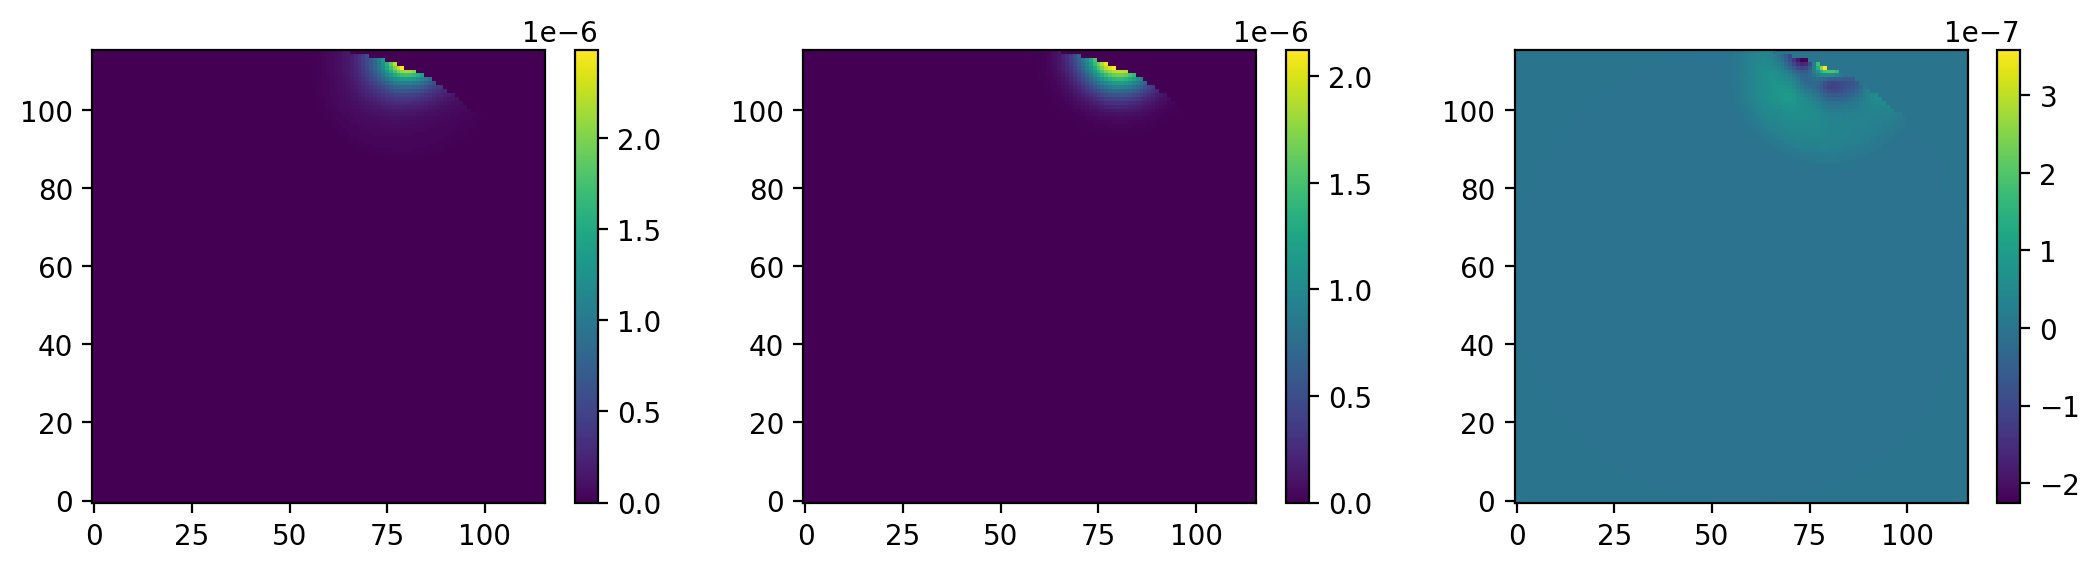

In [20]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches((13,3))
fig.dpi=200

this_act = 4

data = modes[this_act,...] * circmask
print(np.sqrt(np.sum(data**2)))
im1 = ax1.imshow(data, origin='lower')
clb1 = fig.colorbar(im1, ax=ax1)

fitdata = gaussian_func(*gauss_params[this_act,:])(*np.indices(data.shape)) * circmask
print(np.sqrt(np.sum(fitdata**2)))
im2 = ax2.imshow(fitdata, origin='lower')
clb2 = fig.colorbar(im2, ax=ax2)

diff = (data-fitdata)
print(np.sqrt(np.sum(diff**2)))
im3 = ax3.imshow(diff, origin='lower')
clb3 = fig.colorbar(im3, ax=ax3)

#### Verify fitting of all actuators using metric

Compute the norm of the data, fitted data, and difference

In [21]:
%%time

datanorm = np.zeros(nmodes)
fitdatanorm = np.zeros(nmodes)
diffnorm = np.zeros(nmodes)

for this_act in range(nmodes):
    #print("Analyzing act # %d"%this_act)
    #-- original data
    data = modes[this_act, ...] * circmask
    datanorm[this_act] = np.sqrt(np.sum(data**2))
    #-- fitted data
    fitdata = gaussian_func(*gauss_params[this_act,:])(*np.indices(data.shape)) * circmask
    fitdatanorm[this_act] = np.sqrt(np.sum(fitdata**2))    
    #-- difference
    diffnorm[this_act] = np.sqrt(np.sum((data-fitdata)**2))

CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 234 ms


Text(0, 0.5, 'fitdata norm')

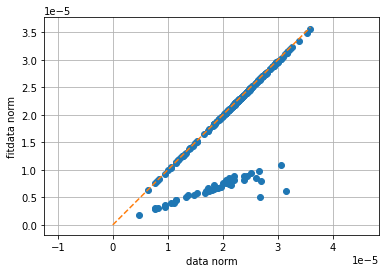

In [22]:
#---- The norms of the data and fitted data should be correlated if fitting is good.
plt.plot(datanorm, fitdatanorm, 'o')
plt.plot([0,np.max(datanorm)],[0,np.max(datanorm)], '--')
plt.axis('equal')
plt.grid()
plt.xlabel('data norm')
plt.ylabel('fitdata norm')

The relative norm seems a good metric to discard bad fittings:

Text(0.5, 0, 'valid actuator number')

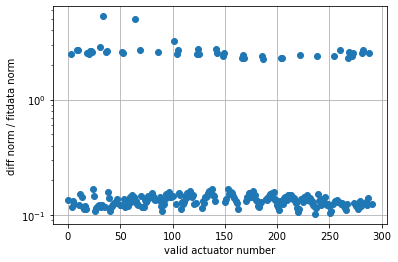

In [23]:
plt.semilogy(diffnorm/fitdatanorm, 'o')
plt.grid()
plt.ylabel('diff norm / fitdata norm')
plt.xlabel('valid actuator number')

In [24]:
subset_valid_acts = diffnorm/fitdatanorm < 1
subset_valid_acts_idx = np.where(subset_valid_acts)[0]

#### Compare max values vs Gaussian peak estimates

In [25]:
gauss_params.shape, peakval.shape, subset_valid_acts.shape

((292, 6), (292,), (292,))

Text(0, 0.5, 'Gauss amp')

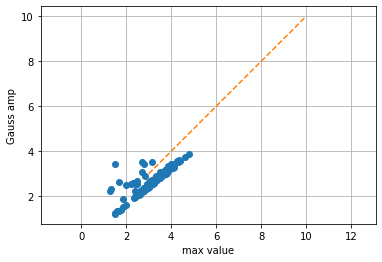

In [26]:
plt.plot(IFpeak[subset_valid_acts_idx]*1e6, peakval[subset_valid_acts]*1e6, 'o')
plt.grid()
plt.axis('equal')
plt.plot([3,10],[3,10], '--')
plt.xlabel('max value')
plt.ylabel('Gauss amp')

Text(0.5, 1.0, 'fitted peak locations')

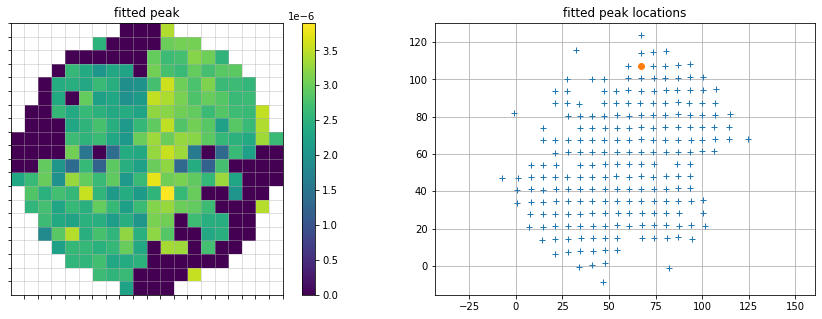

In [57]:
#--- Show peak amplitude and location of all fitted actuators
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches((15,5))
tempvec = np.zeros(292)
tempvec[subset_valid_acts_idx] = peakval[subset_valid_acts]
wfpt_visulib.show_dm292(tempvec, fig=fig, ax=ax1, title='fitted peak',
               grid_origin_bottom_left=True)

ax2.plot(peakloc[subset_valid_acts,0], peakloc[subset_valid_acts,1],'+')

this_act= 16 #subset_valid_acts_idx[7]
ax2.plot(peakloc[this_act,0], peakloc[this_act,1],'o')
ax2.axis('equal')
ax2.grid()
ax2.set_title('fitted peak locations')

## Fit DM grid parameters
Using a subset of actuators influence functions, fit the DM grid model to estimates of peak locations.

In [28]:
from scipy.optimize import minimize

### Define grid fitting function
Note: x flip required to match influence function ordering.

In [60]:
def grid_model(act_pitch_x, act_pitch_y, Rz, pitch_dx, pitch_dy):
    nact_lin = 20 # actuators
    yact1, xact1 = np.where(wfpt_visulib.dm292_actmap())
    xact1 = xact1 - (nact_lin-1)/2
    yact1 = yact1 - (nact_lin-1)/2
    # -- Invert x and y below is equivalent to a rotation of 180 deg
    if mirror=='M2':
        yact1 *= -1
    xact1 *= -1
    #---- Scaling w.r.t center of grid
    xact1 *= act_pitch_x
    yact1 *= act_pitch_y
    #---- Rotate the grid w.r.t center of grid
    ra = -Rz*np.pi/180
    x_act_ = xact1 * np.cos(ra) - yact1 * np.sin(ra)
    y_act_ = xact1 * np.sin(ra) + yact1 * np.cos(ra)
    #---- Shift the grid
    x_act_ += pitch_dx
    y_act_ += pitch_dy
    return x_act_, y_act_

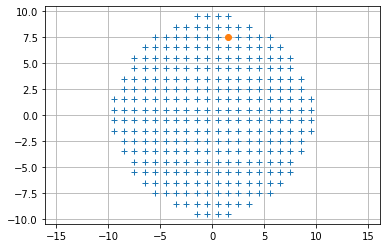

In [61]:
grid0_x, grid0_y = grid_model(1,1,0,0,0)
plt.plot(grid0_x, grid0_y, '+', )
this_act = 16
plt.plot(grid0_x[this_act], grid0_y[this_act], 'o')
plt.axis('equal')
plt.grid()

### Convert to meters
We know that the diameter of the DM292 clear pupil is 26.5 mm

In [62]:
L = 26.5e-3 #diameter of clear pupil.
nact_lin = 20 # actuators
act_pitch_0 = 1.5e-3 #by design from DM292 spreadsheet.

In [63]:
du = L / (ni-1) # pixel scale
peakloc_m = (peakloc - (ni-1)/2) * du

#--- a-priori grid pitch
#act_pitch_0 = L / (nact_lin-1) 
xact, yact = grid_model(act_pitch_0, act_pitch_0, 0, 0, 0)

Text(0.5, 1.0, 'fitted peak locations')

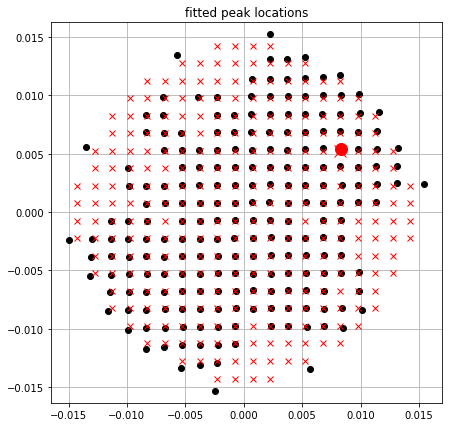

In [65]:
fig, ax2 = plt.subplots()
fig.set_size_inches((7,7))

#--- Choose an actuator to highlight on both a-priori and data grid (they must coincide)
this_act = 73

ax2.plot(peakloc_m[subset_valid_acts,0], peakloc_m[subset_valid_acts,1],'ko')
ax2.plot(xact, yact,'rx') # a-priori peak locations (to be refined)

ax2.plot(peakloc_m[this_act,0], peakloc_m[this_act,1], 'ro', markersize=12)
ax2.plot(xact[this_act], yact[this_act], 'rx', markersize=12)

ax2.axis('equal')
ax2.grid()
ax2.set_title('fitted peak locations')

### Fit the grid
Include scaling, shifts, and rotation

In [66]:
def fitgrid_err_func(params, *args):
    lab_x_act = args[0]
    lab_y_act = args[1]
    subset_idx = args[2]
    
    print("grid adjustments: (pitch_x=%0.4f, pitch_y=%0.4f, Rz=%0.4f, Dx=%0.4f, Dy=%0.4f)"%(params[0],params[1],
                                                                                            params[2],params[3],params[4]))
    fit_x_act, fit_y_act = grid_model(params[0], params[1], params[2], params[3], params[4])
    fit_x_act = fit_x_act[subset_idx]
    fit_y_act = fit_y_act[subset_idx]

    err = ((lab_x_act - fit_x_act)**2 + (lab_y_act - fit_y_act)**2).sum()
    return err

Launch the Powell minimization 

In [67]:
%%time

params0 = np.array([act_pitch_0, act_pitch_0, 0, 0, 0]) # initial guess
lab_xact, lab_yact = peakloc_m[subset_valid_acts,0], peakloc_m[subset_valid_acts,1]

res = minimize(fitgrid_err_func, params0, args=(lab_xact, lab_yact, subset_valid_acts_idx), 
         method='Powell', bounds=[( 1.3e-3,  1.7e-3),
                                  ( 1.3e-3,  1.7e-3),
                                  (-10.0,10.0),
                                  (-2e-3, 2e-3),
                                  (-2e-3, 2e-3)], options={'disp':True})
res

grid adjustments: (pitch_x=0.0015, pitch_y=0.0015, Rz=0.0000, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0015, pitch_y=0.0015, Rz=0.0000, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0015, pitch_y=0.0015, Rz=0.0000, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0016, pitch_y=0.0015, Rz=0.0000, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0015, pitch_y=0.0015, Rz=0.0000, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0015, pitch_y=0.0015, Rz=0.0000, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0015, pitch_y=0.0015, Rz=0.0000, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0015, pitch_y=0.0016, Rz=0.0000, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0015, pitch_y=0.0015, Rz=0.0000, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0015, pitch_y=0.0015, Rz=-2.3607, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0015, pitch_y=0.0015, Rz=2.3607, Dx=0.0000, Dy=0.0000)
grid adjustments: (pitch_x=0.0015, pitch_y=0.0015, Rz=-5.2786, Dx=0.0000, D

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 6.571049839146848e-06
       x: [ 1.514e-03  1.514e-03 -3.577e-01 -1.201e-05  4.151e-05]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 56

In [68]:
new_pitch_x = res['x'][0]
new_pitch_y = res['x'][1]
new_angle   = res['x'][2]
new_pitch_dx = res['x'][3]
new_pitch_dy = res['x'][4]
new_xact, new_yact = grid_model(new_pitch_x, new_pitch_y, new_angle, new_pitch_dx, new_pitch_dy)

Confirm there is no pitch compression

In [70]:
new_pitch_x*1e3, new_pitch_y*1e3, new_pitch_x/new_pitch_y, np.arccos(new_pitch_x/new_pitch_y)*180/np.pi

(1.5138802616722113, 1.5138802616722113, 1.0, 0.0)

### Show the final grid

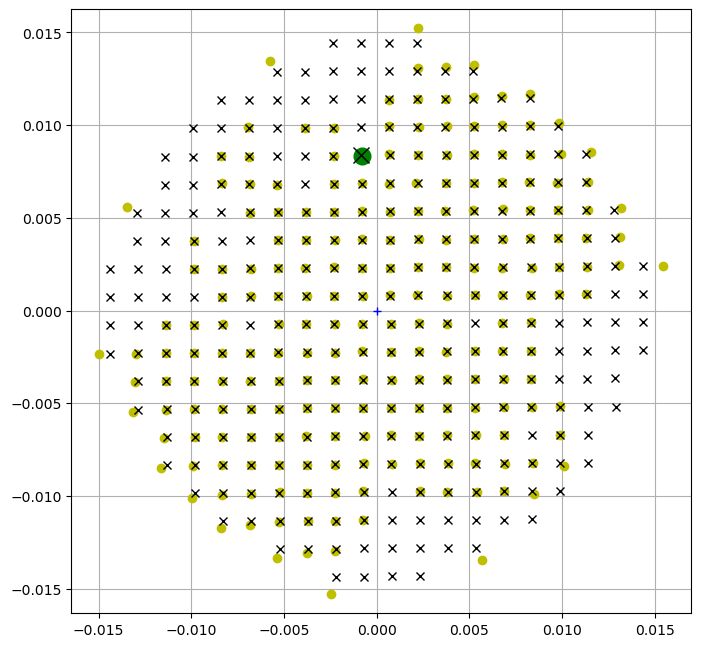

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
fig.dpi=100
ax.plot(lab_xact, lab_yact, 'yo')
ax.plot(new_xact, new_yact, 'kx')
ax.plot(0, 0, 'b+')

#--- Choose an actuator to highlight on both a-priori and data grid (they must coincide)
this_act = 46
ax.plot(peakloc_m[this_act,0], peakloc_m[this_act,1], 'go', markersize=12)
ax.plot(new_xact[this_act], new_yact[this_act], 'kx', markersize=12)

ax.grid()
ax.axis('equal');

In [73]:
Dtel = 25.4 # size of GMT pupil [m]
Dtel_mm = 24.5e-3 # size of GMT pupil [mm] over DM grid
act_pitch_0_m = (Dtel / Dtel_mm) * act_pitch_0
print('actuator pitch projected onto M1 [m]: %0.3f'%act_pitch_0_m)

actuator pitch projected onto M1 [m]: 1.555
